<img src="images/keepcoding.png" width=200 align="left">

# Módulo de Matemáticas 101: práctica

Vamos a poner de nuevo en práctica lo que hemos visto en este módulo. La práctica se centra en la regresión lineal (¡tema muy importante!) y podéis preguntarme las dudas que tengáis por Discord. ¡Mucha suerte!

<img src="./images/luck.gif" alt="Drawing" style="width: 300px;"/>

## 1. Regresión lineal con mínimos cuadrados

En este ejercicio vamos a implementar la forma matricial de la regresión lineal con el método de los mínimos cuadrados. Para ello, tendrás que:

- Explorar un dataset
- Implementar la regresión lineal
- Aplicarla a los datos

Como recordatorio, los valores de los pesos $\widehat{w}$ vienen dados por:

$\widehat{w} = (X^T X)^{-1}X^T y,$</center>

Donde $y$ es la variable a predecir y $X$ la matriz de features (NOTA: revisa cómo se define en los apuntes). Sabemos que los pesos van a ser los parámetros de la ecuación lineal que estamos intentando ajustar y tendremos uno por cada variable de entrada que usemos y además un término independiente o bias.

### 1.1 Carga del dataset y exploración de datos

Vamos a usar el dataset de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) que podemos encontrar en el [repositorio de Machine learning de UC Irvine](https://archive.ics.uci.edu/). Lo primero, vamos a familiarizarnos con los datos.

En el propio repositorio nos indican cómo descargar el dataset con su librería (podemos consultar el código fuente si queremos).

In [31]:
from ucimlrepo import fetch_ucirepo
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandasfrom ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# metadata 
print(auto_mpg.metadata) 
  
# variable information 
print(auto_mpg.variables) 


{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

Con la función `head` de Pandas podemos ver las primeras filas del dataset.

In [32]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [33]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


In [34]:
X.cylinders

0      8
1      8
2      8
3      8
4      8
      ..
393    4
394    4
395    4
396    4
397    4
Name: cylinders, Length: 398, dtype: int64

In [35]:
X.weight

0      3504
1      3693
2      3436
3      3433
4      3449
       ... 
393    2790
394    2130
395    2295
396    2625
397    2720
Name: weight, Length: 398, dtype: int64

Crea una función a la que le pases los dataframes de features y de target y el nombre de la variable y haga la gráfica del target (consumo en galones por milla) vs la variable que le ha llegado por parámetro. Puedes ver un ejemplo de gráfica más abajo.

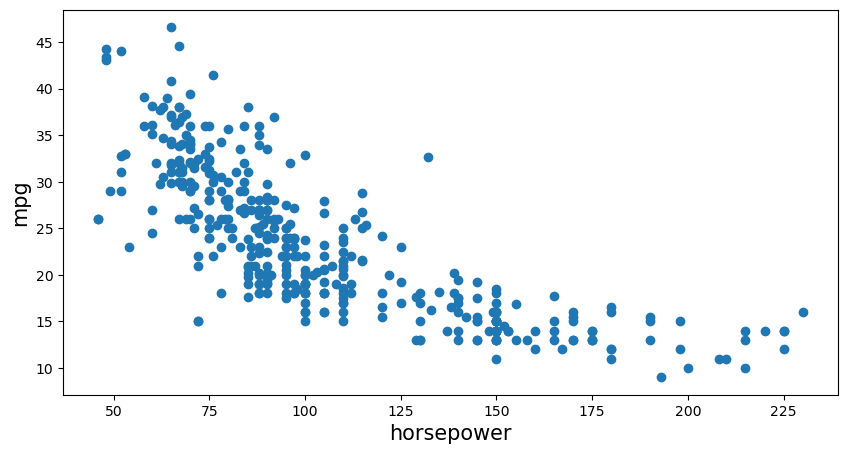

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def visualiza(df, y, nombre_columna):
    """
    Función la que tiene como entrada un dataframe de diferentes variables de un vehículo, como peso,
    números de cilindros, etc... y un target, el consumo del vehículo. Se le específica la variable 
    en nombre de columna.
    La salida es la visualizón de la nube de puntos que se genera
    Utiliza la librería numpy y matplotlib
    """
    y_1d = np.array(y).ravel()
    x = df[nombre_columna]
    plt.figure(figsize=(10,5))
    plt.xlabel(f"{nombre_columna}", fontsize = 15)
    plt.ylabel("mpg", fontsize = 15)
    plt.scatter(x, y_1d)

def visualiza_seaborn (X , Y , columna):
    """
    Función la que tiene como entrada un dataframe de diferentes variables de un vehículo, como peso,
    números de cilindros, etc... y un target, el consumo del vehículo. Se le específica la variable 
    en nombre de columna.
    La salida es la visualizón de la nube de puntos que se genera
    Utiliza la librería seaborn y matplotlib
    """
    sns.regplot(x=X[columna],y=Y,data = X)
    plt.title(f"Relación entre mpg y {columna}")
    plt.xlabel(columna)
    plt.ylabel("mpg")

visualiza(X, y, 'horsepower')

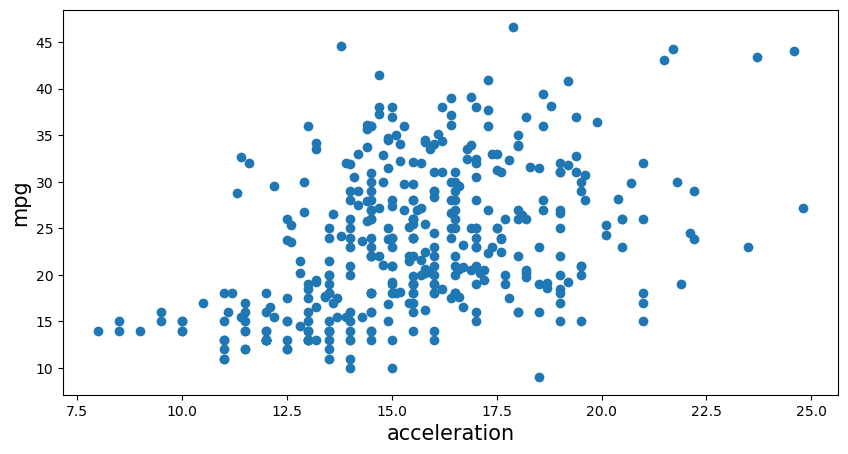

In [37]:
visualiza(X, y, 'acceleration')

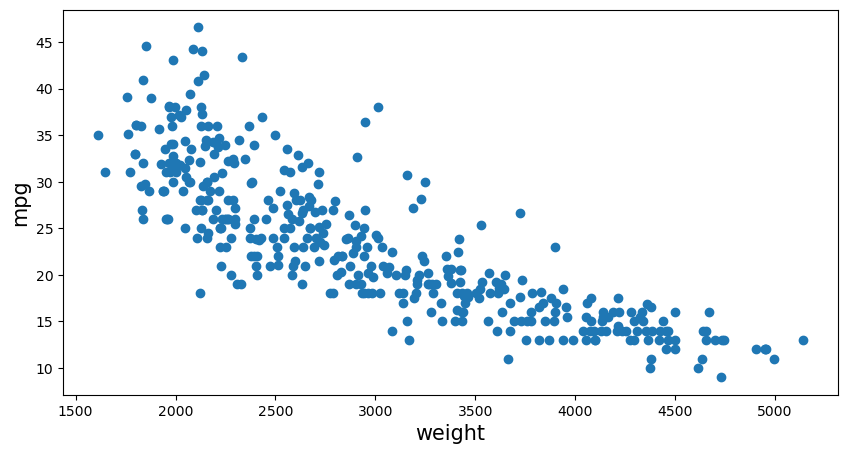

In [38]:
visualiza(X, y, 'weight')

Aunque lo ideal sería un modelo multivariante, vamos a elegir la variable `weight` y hacer una regresión lineal solo con esta variable.

### 1.2 Implementación del modelo

Lo primero, implementa una función que devuelva los valores de $\widehat{w}$ dados X e y. Si se da el caso de que el dataset tiene más features que observaciones, queremos transponerlo antes de realizar las operaciones. Lo hacemos porque, como vimos en clase, los resultados no van a ser buenos si el número de observaciones es menor.

In [39]:
def weight_ols_and_rss(X, y, coln):
    """
    Calcula los pesos w de la regresión lineal.
    """
    X = np.array(X[coln])
    y = np.array(y).ravel()
    if X.ndim != y.ndim:
        X = X.reshape(y.shape)
    ones = np.ones((X.shape[0], 1))
    X_b = np.concatenate((ones, X.reshape(-1, 1)), axis=1)
    w_hat, sum_sq_res, _,_  = np.linalg.lstsq(X_b, y, rcond = None)
    return w_hat, sum_sq_res

In [40]:
weight_ols_and_rss(X, y,'weight')

(array([ 4.63173644e+01, -7.67661006e-03]), array([7474.81401438]))

### 1.3 Prueba del modelo en los datos de consumo de coches

Ya podemos usar nuestra función `pesos` en el dataset real que hemos descargado. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas.

In [41]:
def regression_line(X, y, coln):
  """
  Esta función dibuja la recta de regresión junto con la nube de puntos.
  """
  w_hat,sum_sq_res = weight_ols_and_rss(X, y, coln)

  plt.scatter(X[coln], y)
  plt.plot(X[coln], w_hat[0] + w_hat[1] * X[coln], color='red')
  plt.xlabel(coln)
  plt.ylabel('mpg')
  plt.title('Lineal Regression')
  plt.show()
  print("The sum of squared residuals is: ",sum_sq_res[0])

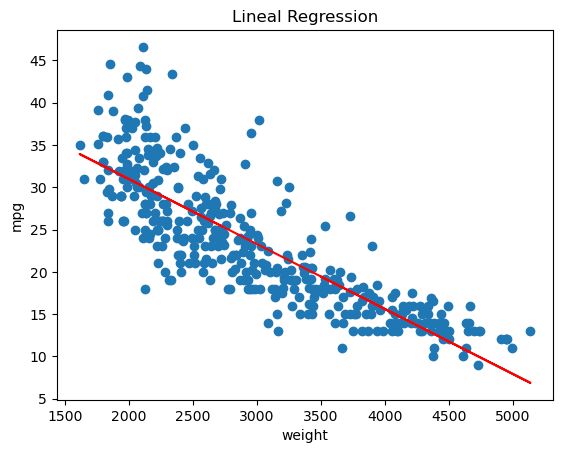

The sum of squared residuals is:  7474.814014382102


In [42]:
regression_line(X, y, 'weight')

Por último, vamos a comprar el resultado con el que nos da `scikit-learn`para ver si nuestra implementación tiene buena pinta. Podemos ver cómo funciona en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [43]:
from sklearn.linear_model import LinearRegression

# Creamos el objeto
lr = LinearRegression()

# Le pasamos los datos en el formato correcto
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

X_lr = X[['weight']]
y_lr = y

# Entrenamos con los datos
lr.fit(X_lr,y_lr)
print("Punto de corte:", lr.intercept_)
print("Pendiente:", lr.coef_[0])

Punto de corte: [46.31736442]
Pendiente: [-0.00767661]


**TODO**: Analiza el resultado obtenido y compáralo con el de sklearn

El resultado que nos proporciona el método de mínimos cuadrados calculando los parámetros de la regresión lineal con nuestra función pesos_ols(X,y, nombre_columna), arroja una pendiente, Pendiente = -7.6766100639264695e-03 y un punto de corte, Punto de Corte = 4.6317364420265605e+01. Si lo comparamos con el resultado arroja el método aplicado en scikit-learn, punto de corte, Punto de corte: 46.31736442 y pendiente, Pendiente: -0.00767661, podemos ver que se asemejan mucho. En el siguiente gráfico se muestra la variación de un método a otro. Las pequeñas diferencias entre aplicar una vía u otra se debe a la manera que los datos son tratados y procesados.

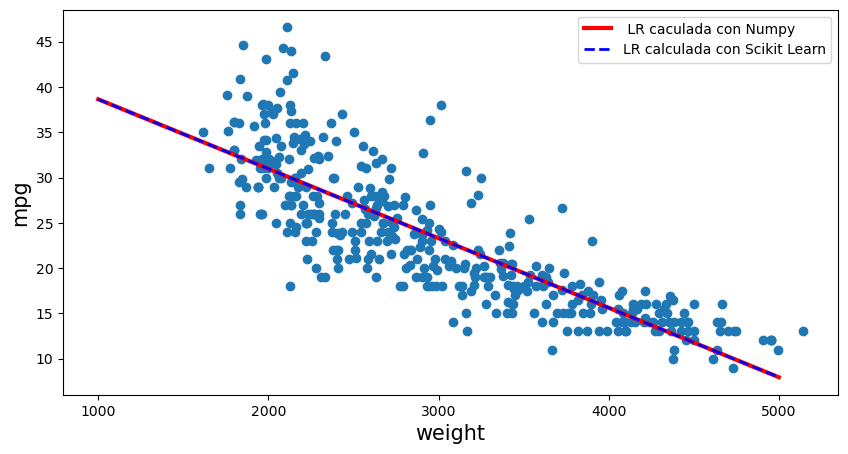

In [44]:
#Visuslización nube de puntos
visualiza(X, y, 'weight')
w_hat, _ = weight_ols_and_rss(X, y, 'weight')

#Dibujo de LR calculada con Numpy
def f(x, w_hat):
    return w_hat[1]*x + w_hat[0]
x = range(1000, 5000)
plt.plot(x, [f(i,w_hat) for i in x], linewidth = 3, color = 'r', label = ' LR caculada con Numpy')
plt.legend()

#Dibujo de LR calculada con scikit learn
a = lr.coef_[0]
b = lr.intercept_
def f(x_scikit,a,b):
    return a*x_scikit + b
x_scikit = range(1000, 5000) 
plt.plot(x_scikit, [f(i,a,b) for i in x_scikit],linestyle = '--',
         linewidth = 2, color = 'b', label = 'LR calculada con Scikit Learn')
plt.legend()

## 2. Optimización con descenso del gradiente

Vamos a resolver el mismo problema usando el descenso del gradiente en lugar de la solución analítica. El descenso del gradiente es un método de optimización iterativo que usa el operador gradiente.

Como es iterativo, necesitamos decirle cuándo tiene que parar y darnos la solución. En este caso, le vamos a decir que pare y nos devuelva la solución después de un número de iteraciones que le pasaremos como parámetro. La ecuación iterativa es.

$$w^{t+1} = w^t - \eta \cdot \nabla f(w)$$

donde f es nuestra función objetivo, y w es un vector. Para la función objetivo, vamos a usar el error RSS, que querremos minimizar.

$$ RSS(w) = \frac{1}{2}\sum_{n=1}^{N}[y_n-f(x_n)]^2$$

y cuyo gradiente es:

$$\nabla RSS(w) = X^T(Xw^t-y)$$

TIP: Ten en cuenta que el RSS también lo puedes escribir como $\frac{1}{2}\sum_{n=1}^{N}[y_n-\hat{y_n}]^2$ donde $\hat{y_n} = X \hat{w}$ en cada paso.

### 2.0 Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal

Ambos métodos, tanto el de mínimos cuadrados como el descenso del gradiente son estimadores usados para calcular los parámetros de una regresión lineal. Aunque sirvan para el mismo objetivos cada uno tiene sus particularidades.

#### Mínimos cuadrados(OLS):

1. Enfoque: Resuelve la ecuación normal para encontrar la solución óptima directamente.
2. Ventajas:
Solución exacta en un solo paso.
Eficiente para conjuntos de datos pequeños.
3. Desventajas:
Computacionalmente costoso para conjuntos de datos grandes, ya que implica calcular la inversa de una matriz.
Puede ser numéricamente inestable si la matriz es singular o casi singular.

#### Descenso del gradiente(GD)

1. Enfoque: Utiliza un proceso iterativo para minimizar la función de coste.
2. Ventajas:
Eficiente para conjuntos de datos grandes.
Más robusto numéricamente.
3. Desventajas:
Requiere la selección de una tasa de aprendizaje adecuada.
Puede converger a un mínimo local en lugar de un mínimo global.
Puede requerir muchas iteraciones para converger.

#### En resumen:

OLS es sensible a la multicolinealidad, mientras que GD es más robusto.
GD puede converger a un mínimo local, mientras que OLS garantiza la solución óptima global.
La convergencia de GD depende de la tasa de aprendizaje y del número de iteraciones.
OLS es adecuado para conjuntos de datos pequeños con baja dimensionalidad, mientras que GD es más apropiado para conjuntos de datos grandes y de alta dimensionalidad. La elección del método depende del tamaño del conjunto de datos, la dimensionalidad y la presencia de multicolinealidad.

### 2.1 Implementar el descenso del gradiente

Completa las siguientes funciones para implementar el descenso del gradiente con la función objetivo de la regresión lineal. La función necesitará:

- La entrada X y salida y de la regresión
- Un punto inicial desde el que empezar a iterar
- El número de iteraciones 
- El learning rate

La función nos devolverá un array con las w resultantes de las iteraciones y otro con el valor de la función en cada paso del algoritmo, a la que también se conoce como *loss function*.

In [45]:
import numpy as np

def gradient_descent(X, y, w0, n_iter, eta): 
    loss = [np.inf]
    w_iter = w0
    w= [w0]
    X_ones = np.concatenate((X, np.ones(X.shape[0]).reshape(X.shape[0], 1)), axis = 1)
     
    for i in range(n_iter):
        print('Iteracion: '+ str(i))
        y_hat = np.dot(X_ones, w_iter)
        error = (y_hat - y)
        loss_iter = (1/2)*(error.T@error)
        grad_rss = X_ones.T@error
        w_iter = w_iter -eta*grad_rss

        w.append(w_iter)
        loss.append(loss_iter)

        print(w_iter)
        print(loss_iter)
    
    return w, loss


eta = 0.01 
iteraciones = 2000 

np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))

y = np.array([208500, 181500, 223500, 140000, 250000]).reshape((5,1))
X = np.array( [[  0.37020659],
               [  -0.48234664],
               [  0.51483616],
               [  0.38352774],
               [  1.29888065]])

weights, loss = gradient_descent(X, y, w0, iteraciones, eta)

print('Resultado w1 y w0',weights[-1])
print(loss)

Iteracion: 0
[[ 4831.89417454]
 [10035.25731026]]
[[1.04232751e+11]]
Iteracion: 1
[[ 9334.57229486]
 [19467.74440188]]
[[9.22102923e+10]]
Iteracion: 2
[[13529.40424345]
 [28334.72159481]]
[[8.16217148e+10]]
Iteracion: 3
[[17435.78206671]
 [36670.88329836]]
[[7.22955621e+10]]
Iteracion: 4
[[21071.89561602]
 [44508.78485696]]
[[6.40808908e+10]]
Iteracion: 5
[[24454.80683112]
 [51878.97457039]]
[[5.68448161e+10]]
Iteracion: 6
[[27600.5194367 ]
 [58810.11756417]]
[[5.04703516e+10]]
Iteracion: 7
[[30524.04433534]
 [65329.11201316]]
[[4.48545065e+10]]
Iteracion: 8
[[33239.46096259]
 [71461.19819048]]
[[3.99066109e+10]]
Iteracion: 9
[[35759.97485346]
 [77230.06078465]]
[[3.55468421e+10]]
Iteracion: 10
[[38097.97165411]
 [82657.92490055]]
[[3.1704926e+10]]
Iteracion: 11
[[40265.06779841]
 [87765.64613416]]
[[2.83189951e+10]]
Iteracion: 12
[[42272.15805507]
 [92572.79508686]]
[[2.53345823e+10]]
Iteracion: 13
[[44129.46013872]
 [97097.73666266]]
[[2.27037356e+10]]
Iteracion: 14
[[ 45846.55656608

### 2.2 Aplicar al dataset de consumo de combustible

Leemos de nuevo los datos y aplicamos la función que acabamos de programar.

In [46]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import numpy as np
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# convert to numpy
X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

print(X_np.shape)
print(y_np.shape)

(398, 1)
(398, 1)


Para ayudar al algoritmo, vamos a escalar la variable X, restando la media y dividiendo entre la desviación estándar. Después aplicamos la función anterior y dibujamos.

Iteracion: 0
[[0.41034017]
 [1.21063099]]
[[121395.02407837]]
Iteracion: 1
[[0.13559909]
 [2.09832788]]
[[112215.85213125]]
Iteracion: 2
[[-0.12820729]
 [ 2.95069443]]
[[103752.80209558]]
Iteracion: 3
[[-0.38151418]
 [ 3.76913679]]
[[95950.00503298]]
Iteracion: 4
[[-0.62473946]
 [ 4.55500514]]
[[88755.95067391]]
Iteracion: 5
[[-0.85828437]
 [ 5.30959594]]
[[82123.14737195]]
Iteracion: 6
[[-1.08253419]
 [ 6.03415402]]
[[76007.80858708]]
Iteracion: 7
[[-1.29785887]
 [ 6.72987469]]
[[70369.56382824]]
Iteracion: 8
[[-1.50461363]
 [ 7.39790568]]
[[65171.19214697]]
Iteracion: 9
[[-1.70313955]
 [ 8.03934903]]
[[60378.37642286]]
Iteracion: 10
[[-1.89376413]
 [ 8.65526294]]
[[55959.47681857]]
Iteracion: 11
[[-2.07680186]
 [ 9.24666348]]
[[51885.32190905]]
Iteracion: 12
[[-2.25255469]
 [ 9.81452627]]
[[48129.01610598]]
Iteracion: 13
[[-2.42131255]
 [10.35978812]]
[[44665.76210619]]
Iteracion: 14
[[-2.58335385]
 [10.88334856]]
[[41472.69719192]]
Iteracion: 15
[[-2.73894591]
 [11.38607128]]
[[3852

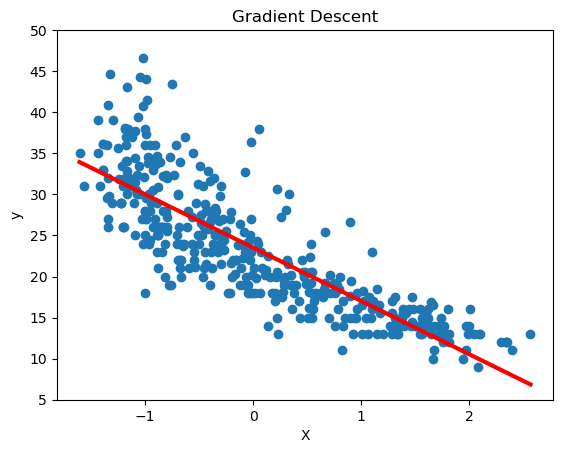

In [47]:
import numpy as np
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import numpy as np

def gradient_descent(X, y, w0, n_iter, eta): 
    loss = [np.inf]
    w_iter = w0
    w= [w0]
    X_ones = np.concatenate((X, np.ones(X.shape[0]).reshape(X.shape[0], 1)), axis = 1)
     
    for i in range(n_iter):
        print('Iteracion: '+ str(i))
        y_hat = np.dot(X_ones, w_iter)
        error = (y_hat - y)
        loss_iter = (1/2)*(error.T@error)
        grad_rss = X_ones.T@error
        w_iter = w_iter -eta*grad_rss

        w.append(w_iter)
        loss.append(loss_iter)

        print(w_iter)
        print(loss_iter)
    
    return w, loss

auto_mpg = fetch_ucirepo(id=9) 
  
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()
 
X_gd=(X_np - X_np.mean()) / X_np.std()
y_gd = y_np

eta = 0.0001
n_iter = 500

np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))
weights, loss = gradient_descent(X_gd,y_gd, w0,n_iter, eta )
w = weights
w1, w0 = weights[-1]

x_max = np.max(X_gd) 
x_min = np.min(X_gd)


w1, w0 = weights[-1]

def f(x,w0, w1):
    return w0 + w1*x

x_range = np.linspace(x_min, x_max, 100)
y_values = f(x_range, w0, w1)

plt.scatter(X_gd, y_gd)  
plt.plot(x_range, y_values, color='red', linewidth = 3)
plt.ylim(5, 50)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gradient Descent')
plt.show()


    

